In [1]:
import schnetpack as spk
import torch
import schnetpack.nn 
import schnetpack.data
import os

#Load last checkpoint file from from trained model
#checkpoint_path = './trained_models/qm9i10e300/checkpoints/checkpoint-10.pth.tar'
#load_checkpoint = torch.load(checkpoint_path)

#prepare directory for the output of the best model after training
qm9i10e300 = './trained_models/qm9i10e300'
if not os.path.exists('./trained_models/qm9i10e300'):
    os.makedirs(qm9i10e300)
from schnetpack.datasets import QM9
qm9data = QM9('./qm9.db', download=True, remove_uncharacterized=True)
train, val, test = spk.data.train_test_split(qm9data, split_file='./trained_models/qm9i5e300/split.npz')
test_loader = spk.AtomsLoader(test, batch_size=100)
train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=100)

atomrefs = qm9data.get_atomref(QM9.U0)
print('U0 of hyrogen:', '{:.2f}'.format(atomrefs[QM9.U0][1][0]), 'eV')
print('U0 of carbon:', '{:.2f}'.format(atomrefs[QM9.U0][6][0]), 'eV')
print('U0 of oxygen:', '{:.2f}'.format(atomrefs[QM9.U0][8][0]), 'eV')


means, stddevs = train_loader.get_statistics(
    QM9.U0, divide_by_atoms=True, single_atom_ref=atomrefs)


print('Mean atomization energy / atom:', means[QM9.U0])
print('Std. dev. atomization energy / atom:', stddevs[QM9.U0])

schnet = spk.representation.SchNet(
    n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=10,
    cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
)
output_U0 = spk.atomistic.Atomwise(n_in=30, atomref=atomrefs[QM9.U0], property=QM9.U0,
                                   mean=means[QM9.U0], contributions=True, stddev=stddevs[QM9.U0])
model = spk.AtomisticModel(representation=schnet, output_modules=output_U0)


U0 of hyrogen: -13.61 eV
U0 of carbon: -1029.86 eV
U0 of oxygen: -2042.61 eV


/home/amerelsamman/Programs/anaconda3/lib/python3.7/site-packages/schnetpack/data/atoms.py:327: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  properties[pname] = torch.FloatTensor(prop)
/home/amerelsamman/Programs/anaconda3/lib/python3.7/site-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Mean atomization energy / atom: tensor([-4.2448])
Std. dev. atomization energy / atom: tensor([0.1894])


/home/amerelsamman/Programs/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Final validation MAE: 0.16 eV = 3.68 kcal/mol


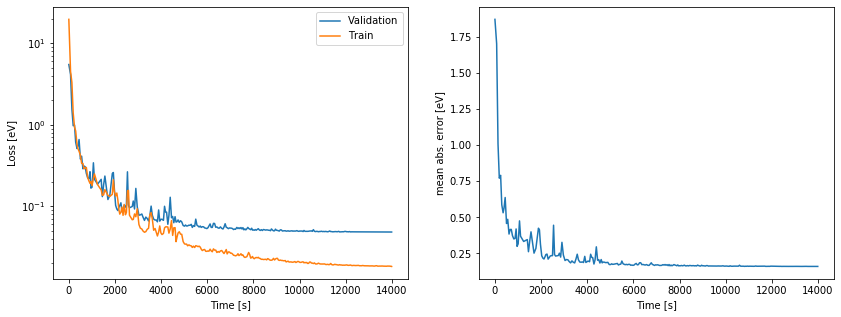

In [2]:
## Training and Validation 
# NOTE You must delete previous best_model if you want to restart the training!

from torch.optim import Adam

# loss function
def mse_loss(batch, result):
    diff = batch[QM9.U0]-result[QM9.U0]
    err_sq = torch.mean(diff ** 2)
    return err_sq

# build optimizer
optimizer = Adam(model.parameters(), lr=1e-2)


import schnetpack.train as trn

loss = trn.build_mse_loss([QM9.U0])

metrics = [spk.metrics.MeanAbsoluteError(QM9.U0)]
hooks = [
    trn.CSVHook(log_path=qm9i10e300, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

trainer = trn.Trainer(
    model_path=qm9i10e300,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    keep_n_checkpoints = 1,
    train_loader=train_loader,
    validation_loader=val_loader,
)

device = "cpu" # change to 'cpu' if gpu is not available
n_epochs = 300 # takes about 10 min on a notebook GPU. reduces for playing around
trainer.train(device=device, n_epochs=n_epochs)

import numpy as np
import matplotlib.pyplot as plt
from ase.units import kcal, mol

results = np.loadtxt(os.path.join(qm9i10e300, 'log.csv'), skiprows=1, delimiter=',')

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

print('Final validation MAE:', np.round(val_mae[-1], 2), 'eV =',
      np.round(val_mae[-1] / (kcal/mol), 2), 'kcal/mol')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(time, val_loss, label='Validation')
plt.plot(time, train_loss, label='Train')
plt.yscale('log')
plt.ylabel('Loss [eV]')
plt.xlabel('Time [s]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, val_mae)
plt.ylabel('mean abs. error [eV]')
plt.xlabel('Time [s]')
plt.show()

